### Extension of ADC and HDR exploration with new target of the idea of look time -- when is the ifcb on average sampling the most and does it change over time

### We then want to create probibity curves for each class and compare how they change over time

##### but lets just start with alexandrium from a handfull of samples I already have

# Steps
1. create a general ingest for this data that i can use more reutinely
2. explore how to graphicaly represent is looking vs is inhibit over time maybe another binary operator
3. graph this operator as a stack of 10 or so bins over run time
4. graph this as a proportion across several bins -- this could then be used for tons of bins
5. Turn the above process into a function so it can be looped over lots of bins in a df
6. thats good for now not sure yet how to do the probibility curve need to think about that some more

### 1. Creating generalized ingest

In [1]:
import pandas as pd

def extract_adc_headers(hdr_file_path):
    """
    Extracts the ADCFileFormat headers from a .hdr file.
    """
    with open(hdr_file_path, 'r') as file:
        for line in file:
            if line.startswith("ADCFileFormat:"):
                header_line = line.strip().split(":", 1)[1]
                headers = [h.strip() for h in header_line.split(",")]
                return headers
    raise ValueError("ADCFileFormat not found in header file.")

def load_adc_data(adc_file_path, headers):
    """
    Loads the .adc file and applies the given headers to the DataFrame.
    """
    df = pd.read_csv(adc_file_path, header=None)
    df.columns = headers[:df.shape[1]]  # Handle case where fewer headers than columns
    return df

def main(hdr_path, adc_path):
    headers = extract_adc_headers(hdr_path)
    adc_df = load_adc_data(adc_path, headers)
    return adc_df

In [2]:
# use the functions to load the dataframe

if __name__ == "__main__":
    hdr_file = "D20240501T235832_IFCB124.hdr"
    adc_file = "D20240501T235832_IFCB124.adc"
    
    adc_df = main(hdr_file, adc_file)
    print(adc_df.head())  # or df.to_csv("output.csv", index=False) to save

FileNotFoundError: [Errno 2] No such file or directory: 'D20240501T235832_IFCB124.hdr'

In [ ]:
# Load the class file
class_df = pd.read_csv('D20240501T235832_IFCB124_class_vNone.csv')

In [ ]:
# Creating ROI number in ADC file and remove zero rois
# Add RoiNumber column starting from 1 in adc file


def clean_ADC_roi(df):
    """
    Remove rows from a DataFrame where RoiX, RoiY, RoiHeight, and RoiWidth are all 0.
    Returns a new cleaned DataFrame.
    """
    df['RoiNumber'] = range(1, len(df) + 1)
    cleandf = df[~((df['RoiX'] == 0) & (df['RoiY'] == 0) &
                   (df['RoiHeight'] == 0) & (df['RoiWidth'] == 0))]

    print(f"Removed {len(df) - len(cleandf)} rows.")
    return cleandf


In [ ]:
cleanADC_df = clean_ADC_roi(adc_df)

In [ ]:
#extract roi from PID from class files
class_df['RoiNumber'] = class_df['pid'].str.split('_').str[-1].astype(int)

In [ ]:
# Reset index to align rows for element-wise comparison
roi_adc = cleanadc_df['RoiNumber'].reset_index(drop=True)
roi_class = class_df['RoiNumber'].reset_index(drop=True)

# Now compare them
differences = roi_adc != roi_class

if differences.any():
    print("Rows with different RoiNumbers:")
    print("cleaned_df values:")
    print(roi_clean[differences])
    print("\nclassdf values:")
    print(roi_class[differences])
else:
    print("All RoiNumbers match by position.")

In [ ]:
cleanadc_df['InhibitTimeDiff'] = cleanadc_df['InhibitTime'].diff().fillna(0)

In [ ]:
# Create VolumeAnalyzed
# First, ensure that the df is a clean copy, not just a filtered set
cleanadc_df = cleanadc_df.copy()
# Then, calculate the volume
cleanadc_df['VolumeAnalyzed'] = (cleanadc_df['RunTime']-cleanadc_df['InhibitTime'])/240

In [ ]:
# Merge just the RoiNumber and VolumeAnalyzed columns into classdf on roi number
class_df = class_df.merge(
    cleanadc_df[['RoiNumber', 'VolumeAnalyzed','RunTime']],
    on='RoiNumber',
    how='left'  # or 'inner' if you want only matching rows
)


In [ ]:
## I gave chat thisb whole notebook and here is what i got for a general function

In [4]:
import pandas as pd
from pathlib import Path

def ingest_ifcb(adc_path: str,
                hdr_path: str,
                class_csv_path: str,
                drop_zero_roi: bool = True):
    """
    Steps:
      1) Parse ADCFileFormat from .hdr to get column names
      2) Load .adc with those headers
      3) Add RoiNumber to ADC as 1..N
      4) Remove rows with RoiX=RoiY=RoiHeight=RoiWidth=0 (optionally)
      5) Add InhibitTimeDiff = diff(InhibitTime).fillna(0)
      6) Add VolumeAnalyzed = (RunTime - InhibitTime) / 240
      7) Load class CSV and extract RoiNumber from pid ('..._00023' -> 23)
      8) Merge class_df with ADC-derived columns on RoiNumber
      9) Return merged_df (and adc_df, class_df)
    """
    adc_path = Path(adc_path)
    hdr_path = Path(hdr_path)
    class_path = Path(class_csv_path)

    # 1) Parse ADCFileFormat from .hdr
    headers = None
    with open(hdr_path, 'r') as f:
        for line in f:
            if line.startswith("ADCFileFormat:"):
                headers = [h.strip() for h in line.split(":", 1)[1].split(",")]
                break
    if not headers:
        raise ValueError("ADCFileFormat not found in header file.")

    # 2) Load .adc with headers
    adc_df = pd.read_csv(adc_path, header=None)
    adc_df.columns = headers[:adc_df.shape[1]]

    # 3) Add RoiNumber to ADC as 1..N (do NOT change after this)
    adc_df["RoiNumber"] = range(1, len(adc_df) + 1)

    # 4) Remove zero-ROI rows (preserving original RoiNumber values)
    if drop_zero_roi:
        roi_cols = ['RoiX', 'RoiY', 'RoiHeight', 'RoiWidth']
        if all(col in adc_df.columns for col in roi_cols):
            keep_mask = ~((adc_df['RoiX'] == 0) &
                          (adc_df['RoiY'] == 0) &
                          (adc_df['RoiHeight'] == 0) &
                          (adc_df['RoiWidth'] == 0))
            adc_df = adc_df.loc[keep_mask]  # keep original RoiNumber; don't reset index

    # 5) InhibitTimeDiff
    if 'InhibitTime' in adc_df.columns:
        # ensure numeric in case strings slipped in
        adc_df['InhibitTime'] = pd.to_numeric(adc_df['InhibitTime'], errors='coerce')
        adc_df['InhibitTimeDiff'] = adc_df['InhibitTime'].diff().fillna(0)
    else:
        adc_df['InhibitTimeDiff'] = pd.NA

    # 6) VolumeAnalyzed
    if {'RunTime', 'InhibitTime'}.issubset(adc_df.columns):
        adc_df['RunTime'] = pd.to_numeric(adc_df['RunTime'], errors='coerce')
        adc_df['VolumeAnalyzed'] = (adc_df['RunTime'] - adc_df['InhibitTime']) / 240
    else:
        adc_df['VolumeAnalyzed'] = pd.NA

    # 7) Load class CSV + extract RoiNumber from pid
    class_df = pd.read_csv(class_path)
    if 'pid' not in class_df.columns:
        raise ValueError("Expected 'pid' column in class CSV to extract RoiNumber.")
    class_df['RoiNumber'] = class_df['pid'].str.split('_').str[-1].astype(int)

    # 8) Merge on RoiNumber
    cols_to_keep = ['RoiNumber', 'RunTime', 'InhibitTime', 'InhibitTimeDiff', 'VolumeAnalyzed']
    for extra in ['RoiHeight', 'RoiWidth', 'RoiX', 'RoiY']:
        if extra in adc_df.columns:
            cols_to_keep.append(extra)

    merged_df = class_df.merge(adc_df[cols_to_keep], on='RoiNumber', how='left')

    # 9) Return
    return merged_df, adc_df, class_df


In [6]:
merged, adc_df, class_df = ingest_ifcb(
    adc_path="../IFCBData/D20240501T235832_IFCB124.adc",
    hdr_path="../IFCBData/D20240501T235832_IFCB124.hdr" ,
    class_csv_path= "../IFCBData/D20240501T235832_IFCB124_class_vNone.csv" ,
    drop_zero_roi= True
)

In [7]:
print(merged.columns.tolist())


['pid', 'Alexandrium_catenella', 'Alexandrium_catenella_TAG_2cell_TAG_chain', 'Alexandrium_catenella_TAG_4cell_TAG_chain', 'Alexandrium_catenella_TAG_dividing', 'Alexandrium_catenella_TAG_fusing', 'Amoeba', 'Amylax', 'Apedinella', 'Asterionellopsis_glacialis', 'Bacillariophyceae_morphotype1', 'Balanion', 'Calciopappus', 'Cerataulina_pelagica', 'Chaetoceros', 'Chaetoceros_TAG_external_pennate', 'Chaetoceros_didymus', 'Chaetoceros_didymus_TAG_external_flagellate', 'Chaetoceros_morphotype1', 'Chaetoceros_similis', 'Chaetoceros_socialis', 'Chaetoceros_subtilis', 'Chaetoceros_tenuissimus', 'Chrysochromulina', 'Chrysochromulina_lanceolata', 'Ciliophora', 'Copepod_nauplii', 'Corethron_hystrix', 'Corymbellus', 'Coscinodiscus', 'Cryptophyta', 'Cylindrotheca', 'Dactyliosolen_blavyanus', 'Dactyliosolen_fragilissimus', 'Delphineis', 'Dictyocha', 'Dinobryon', 'Dinophysis_acuminata', 'Dinophysis_acuminata_TAG_dividing', 'Dinophysis_acuminata_TAG_mating', 'Dinophysis_norvegica', 'Ditylum_brightwellii

In [8]:
print(adc_df.columns.tolist())


['trigger#', 'ADCtime', 'PMTA', 'PMTB', 'PMTC', 'PMTD', 'PeakA', 'PeakB', 'PeakC', 'PeakD', 'TimeOfFlight', 'GrabTimeStart', 'GrabTimeEnd', 'RoiX', 'RoiY', 'RoiWidth', 'RoiHeight', 'StartByte', 'ComparatorOut', 'StartPoint', 'SignalLength', 'Status', 'RunTime', 'InhibitTime', 'RoiNumber', 'InhibitTimeDiff', 'VolumeAnalyzed']


In [9]:
print(class_df.columns.tolist())

['pid', 'Alexandrium_catenella', 'Alexandrium_catenella_TAG_2cell_TAG_chain', 'Alexandrium_catenella_TAG_4cell_TAG_chain', 'Alexandrium_catenella_TAG_dividing', 'Alexandrium_catenella_TAG_fusing', 'Amoeba', 'Amylax', 'Apedinella', 'Asterionellopsis_glacialis', 'Bacillariophyceae_morphotype1', 'Balanion', 'Calciopappus', 'Cerataulina_pelagica', 'Chaetoceros', 'Chaetoceros_TAG_external_pennate', 'Chaetoceros_didymus', 'Chaetoceros_didymus_TAG_external_flagellate', 'Chaetoceros_morphotype1', 'Chaetoceros_similis', 'Chaetoceros_socialis', 'Chaetoceros_subtilis', 'Chaetoceros_tenuissimus', 'Chrysochromulina', 'Chrysochromulina_lanceolata', 'Ciliophora', 'Copepod_nauplii', 'Corethron_hystrix', 'Corymbellus', 'Coscinodiscus', 'Cryptophyta', 'Cylindrotheca', 'Dactyliosolen_blavyanus', 'Dactyliosolen_fragilissimus', 'Delphineis', 'Dictyocha', 'Dinobryon', 'Dinophysis_acuminata', 'Dinophysis_acuminata_TAG_dividing', 'Dinophysis_acuminata_TAG_mating', 'Dinophysis_norvegica', 'Ditylum_brightwellii

### cool that works atleast on first glance so that is a cool little function that probably is not super generalixable but its fine

## example usage
```python
merged, adc_df, class_df = ingest_ifcb(
    adc_path="../D20240501T235832_IFCB124.adc",
    hdr_path="../D20240501T235832_IFCB124.hdr" ,
    class_csv_path= "../D20240501T235832_IFCB124_class_vNone.csv" ,
    drop_zero_roi= True
)
```

# 2.  explore how to graphicaly represent is looking vs is inhibit over time maybe another binary operator

In [10]:
print(adc_df.head())
print(adc_df.tail())


   trigger#   ADCtime      PMTA      PMTB      PMTC      PMTD     PeakA  \
1         2  3.980360  0.299355  0.025022  0.002900  0.005373  2.464631   
2         3  5.251457  0.002476  0.004637  0.002815  0.004824  0.112133   
3         4  5.660039  0.008661  0.029319  0.002841  0.005122  0.148821   
4         5  6.286795  0.019144  0.341973  0.002939  0.005664  0.208952   
5         6  7.194931  0.001565  0.003712  0.002784  0.004782  0.024881   

      PeakB     PeakC     PeakD  ...  StartByte  ComparatorOut  StartPoint  \
1  0.221434  0.015581  0.019419  ...          0              0           0   
2  0.143795  0.015440  0.019228  ...      48608              0           0   
3  0.457547  0.015526  0.019319  ...      56224              0           0   
4  3.130853  0.015631  0.019395  ...      62912              0           0   
5  0.125811  0.015287  0.019059  ...      77600              0           0   

   SignalLength  Status   RunTime  InhibitTime  RoiNumber  InhibitTimeDiff  \
1 

### How the logic works
adc data is a discrete measure of a continuous process so we need to intepret what is happening between samples at run time and then add the inhibit time after that

this first sorts the df by run time to make sure its chronological -- probably unnecisary but a good safety step
then computes dt as time between samples runtime(i) - runtime(i-1)
the compute dI for new inhibit time added = inhibittime(i) - inhibittime(i-1)

It does some edge case and noise handling bascialy gives it a amount of error so if seconds do not match up exactly the program odes not break

if between two time intervals  total time elapsed (dt) = running time + inhibit time (dI)
then 
running time = dt - dI

then we can just plot for each interval between two observations 
draw a red line from t0 to t0+inhibit time meaning from when the roi is captured to when the inhibit time is done and it goes back to looking
then draw a blue segment from t0+inhibit to t1 as in when the next sample begins

and loops through this for every instance in the adc file
it makes some rough summary statistics of total time inhibited and looking and total run time and some percentages



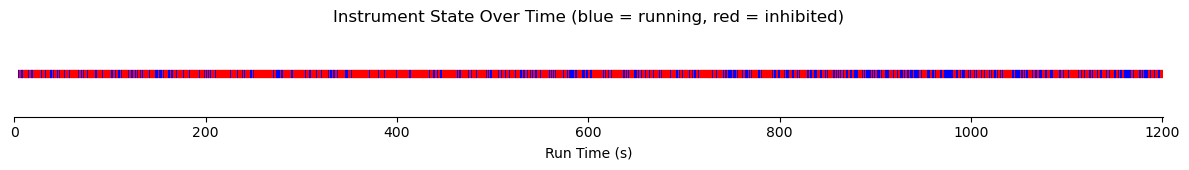

Total elapsed (by segments): 1197.038 s
  Running:  415.267 s (34.7%)
  Inhibited:781.771 s (65.3%)
Final InhibitTime reported: 781.897 s
Final RunTime reported:     1201.039 s


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assume adc_df exists with columns RunTime, InhibitTime
df = adc_df.copy()
df['RunTime'] = pd.to_numeric(df['RunTime'], errors='coerce')
df['InhibitTime'] = pd.to_numeric(df['InhibitTime'], errors='coerce')
df = df.dropna(subset=['RunTime','InhibitTime']).sort_values('RunTime').reset_index(drop=True)

# need at least 2 rows
if len(df) < 2:
    raise ValueError("Need >= 2 rows with RunTime & InhibitTime.")

# compute deltas
dt = df['RunTime'].diff().to_numpy()         # elapsed time between samples
dI = df['InhibitTime'].diff().to_numpy()     # change in inhibited time

# tolerances to kill jitter
ABS_TOL = 1e-6
dI = np.where(dI > ABS_TOL, dI, 0.0)

# clamp to [0, dt] and handle any bad/zero dt
dt = np.where(np.isfinite(dt), dt, 0.0)
dI = np.where(np.isfinite(dI), dI, 0.0)
dt = np.where(dt < 0, 0.0, dt)
dI = np.clip(dI, 0.0, dt)

# build colored segments along baseline
x = df['RunTime'].to_numpy()
fig, ax = plt.subplots(figsize=(12, 1.8))
y0 = 0.0

total_inhib = 0.0
total_run = 0.0

for i in range(1, len(df)):
    x0 = float(x[i-1]); x1 = float(x[i])
    if not np.isfinite(x0) or not np.isfinite(x1) or x1 <= x0:
        continue
    di = float(dI[i]); drun = float(dt[i] - di)

    # draw inhibited part first (red), then running part (blue)
    # (ordering within the interval is unknown; this is a visualization choice)
    cur = x0
    if di > 0:
        ax.plot([cur, cur+di], [y0, y0], color='red', linewidth=6, solid_capstyle='butt')
        cur += di
        total_inhib += di
    if drun > 0:
        ax.plot([cur, x1], [y0, y0], color='blue', linewidth=6, solid_capstyle='butt')
        total_run += drun

# pretty up
ax.set_xlim(0, float(df['RunTime'].max()))
ax.set_ylim(-0.5, 0.5)
ax.set_yticks([])
ax.set_xlabel('Run Time (s)')
ax.set_title('Instrument State Over Time (blue = running, red = inhibited)')
for sp in ['left','right','top']:
    ax.spines[sp].set_visible(False)
ax.grid(False)
plt.tight_layout()
plt.show()

# sanity check: totals
total_elapsed = total_run + total_inhib
print(f"Total elapsed (by segments): {total_elapsed:.3f} s")
print(f"  Running:  {total_run:.3f} s ({(total_run/total_elapsed*100 if total_elapsed else 0):.1f}%)")
print(f"  Inhibited:{total_inhib:.3f} s ({(total_inhib/total_elapsed*100 if total_elapsed else 0):.1f}%)")

# optional: compare to cumulative values in data
if np.isfinite(df['InhibitTime'].iloc[-1]):
    print(f"Final InhibitTime reported: {df['InhibitTime'].iloc[-1]:.3f} s")
if np.isfinite(df['RunTime'].iloc[-1]):
    print(f"Final RunTime reported:     {df['RunTime'].iloc[-1]:.3f} s")


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Dict

def plot_instrument_state_time(
    adc_df: pd.DataFrame,
    abs_tol: float = 1e-6,
    ax: Optional[plt.Axes] = None,
    save_path: Optional[str] = None,
    xlabel: str = "Run Time (s)",
    title: str = "Instrument State Over Time (red = inhibited first, blue = running/waiting)"
) -> Dict[str, float]:
    """
    Plot a horizontal timeline from RunTime=0 to final RunTime (seconds).
    For each interval (i-1 -> i):
        Δt = RunTime[i] - RunTime[i-1]          # elapsed wall time
        ΔI = InhibitTime[i] - InhibitTime[i-1]  # newly inhibited time
      Then:
        inhibited = clamp(ΔI, 0, Δt)
        running   = Δt - inhibited
    Draw order: red (inhibited) first, then blue (running/waiting).

    Parameters
    ----------
    adc_df : DataFrame with numeric 'RunTime' and 'InhibitTime'
    abs_tol : treat tiny ΔI as zero to suppress jitter
    ax : optional Matplotlib Axes; if None, a new figure is created
    save_path : optional path to save the figure
    xlabel, title : labels

    Returns
    -------
    dict with totals (seconds):
      {
        'total_elapsed_s', 'total_running_s', 'total_inhibited_s',
        'final_runtime_s', 'final_inhibittime_s'
      }
    """
    # Prepare/clean
    df = adc_df.copy()
    df['RunTime'] = pd.to_numeric(df['RunTime'], errors='coerce')
    df['InhibitTime'] = pd.to_numeric(df['InhibitTime'], errors='coerce')
    df = df.dropna(subset=['RunTime','InhibitTime']).sort_values('RunTime').reset_index(drop=True)
    if len(df) < 2:
        raise ValueError("Need >= 2 rows with RunTime & InhibitTime to plot timeline.")

    # Deltas (seconds)
    dt = df['RunTime'].diff().to_numpy()
    dI = df['InhibitTime'].diff().to_numpy()

    # Jitter handling & clamping
    dI = np.where(dI > abs_tol, dI, 0.0)
    dt = np.where(np.isfinite(dt), dt, 0.0)
    dI = np.where(np.isfinite(dI), dI, 0.0)
    dt = np.where(dt < 0, 0.0, dt)
    dI = np.clip(dI, 0.0, dt)  # can't inhibit longer than the interval

    # Axis setup
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 1.8))
        created_fig = True

    x = df['RunTime'].to_numpy()
    y0 = 0.0
    total_inhib_s = 0.0
    total_run_s = 0.0

    # Draw: inhibited (red) first, then running (blue)
    for i in range(1, len(df)):
        x0 = float(x[i-1]); x1 = float(x[i])
        if not np.isfinite(x0) or not np.isfinite(x1) or x1 <= x0:
            continue

        di = float(dI[i])
        dr = float(dt[i] - di)

        cur = x0
        if di > 0:
            ax.plot([cur, cur+di], [y0, y0], color='red', linewidth=6, solid_capstyle='butt')
            cur += di
            total_inhib_s += di
        if dr > 0:
            ax.plot([cur, x1], [y0, y0], color='blue', linewidth=6, solid_capstyle='butt')
            total_run_s += dr

    # Style
    ax.set_xlim(0, float(df['RunTime'].max()))
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    for sp in ['left','right','top']:
        ax.spines[sp].set_visible(False)
    ax.grid(False)

    if created_fig:
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()

    return {
        'total_elapsed_s': total_run_s + total_inhib_s,
        'total_running_s': total_run_s,
        'total_inhibited_s': total_inhib_s,
        'final_runtime_s': float(df['RunTime'].iloc[-1]),
        'final_inhibittime_s': float(df['InhibitTime'].iloc[-1]),
    }


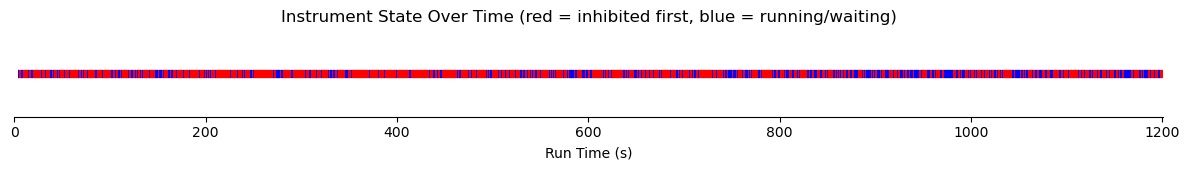

{'total_elapsed_s': 1197.0379427083333, 'total_running_s': 415.2670182291667, 'total_inhibited_s': 781.7709244791666, 'final_runtime_s': 1201.0391666666667, 'final_inhibittime_s': 781.8967361111111}


In [17]:
summary = plot_instrument_state_time(adc_df, abs_tol=1e-4, save_path=None)
print(summary)

In [18]:
## lets try with a less dense sample to see if we are actually dooing this right

merged_sparce, adc_sparce_df, class_sparce_df = ingest_ifcb(
    adc_path="../IFCBData/h_sampling/D20230704T185043_IFCB110.adc",
    hdr_path="../IFCBData/h_sampling/D20230704T185043_IFCB110.hdr" ,
    class_csv_path= "../IFCBData/h_sampling/D20230704T185043_IFCB110_class_vNone.csv" ,
    drop_zero_roi= True
)

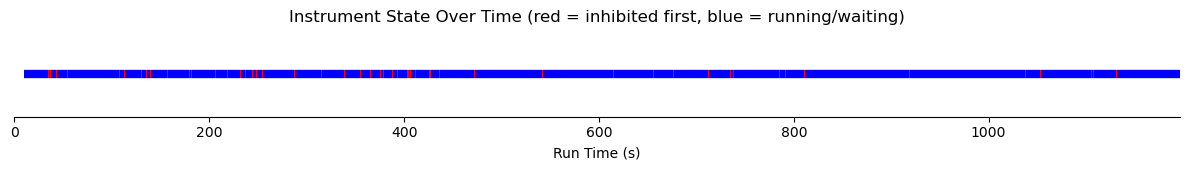

{'total_elapsed_s': 1187.093424479166, 'total_running_s': 1135.226256510416, 'total_inhibited_s': 51.86716796875, 'final_runtime_s': 1196.4, 'final_inhibittime_s': 52.038098958333336}


In [19]:
summarysparce = plot_instrument_state_time( adc_sparce_df, abs_tol=1e-4, save_path=None)
print(summarysparce)

### Or we can do this in terms of ml sample analyzed it should look exactly the same but with a different scale

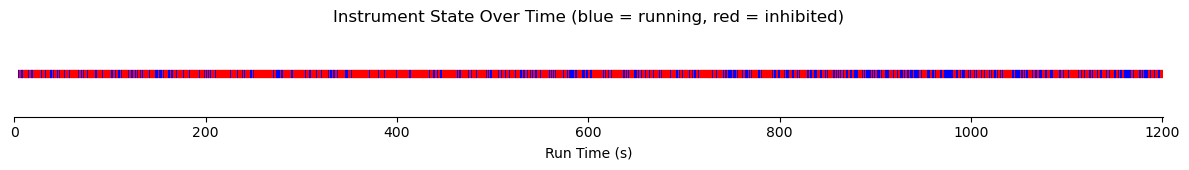

Total elapsed (by segments): 1197.038 s
  Running:  415.267 s (34.7%)
  Inhibited:781.771 s (65.3%)
Final InhibitTime reported: 781.897 s
Final RunTime reported:     1201.039 s


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assume adc_df exists with columns RunTime, InhibitTime
df = adc_df.copy()
df['RunTime'] = pd.to_numeric(df['RunTime'], errors='coerce')
df['InhibitTime'] = pd.to_numeric(df['InhibitTime'], errors='coerce')
df = df.dropna(subset=['RunTime','InhibitTime']).sort_values('RunTime').reset_index(drop=True)

# need at least 2 rows
if len(df) < 2:
    raise ValueError("Need >= 2 rows with RunTime & InhibitTime.")

# compute deltas
dt = df['RunTime'].diff().to_numpy()         # elapsed time between samples
dI = df['InhibitTime'].diff().to_numpy()     # change in inhibited time

# tolerances to kill jitter
ABS_TOL = 1e-6
dI = np.where(dI > ABS_TOL, dI, 0.0)

# clamp to [0, dt] and handle any bad/zero dt
dt = np.where(np.isfinite(dt), dt, 0.0)
dI = np.where(np.isfinite(dI), dI, 0.0)
dt = np.where(dt < 0, 0.0, dt)
dI = np.clip(dI, 0.0, dt)

# build colored segments along baseline
x = df['RunTime'].to_numpy()
fig, ax = plt.subplots(figsize=(12, 1.8))
y0 = 0.0

total_inhib = 0.0
total_run = 0.0

for i in range(1, len(df)):
    x0 = float(x[i-1]); x1 = float(x[i])
    if not np.isfinite(x0) or not np.isfinite(x1) or x1 <= x0:
        continue
    di = float(dI[i]); drun = float(dt[i] - di)

    # draw inhibited part first (red), then running part (blue)
    # (ordering within the interval is unknown; this is a visualization choice)
    cur = x0
    if di > 0:
        ax.plot([cur, cur+di], [y0, y0], color='red', linewidth=6, solid_capstyle='butt')
        cur += di
        total_inhib += di
    if drun > 0:
        ax.plot([cur, x1], [y0, y0], color='blue', linewidth=6, solid_capstyle='butt')
        total_run += drun

# pretty up
ax.set_xlim(0, float(df['RunTime'].max()))
ax.set_ylim(-0.5, 0.5)
ax.set_yticks([])
ax.set_xlabel('Run Time (s)')
ax.set_title('Instrument State Over Time (blue = running, red = inhibited)')
for sp in ['left','right','top']:
    ax.spines[sp].set_visible(False)
ax.grid(False)
plt.tight_layout()
plt.show()

# sanity check: totals
total_elapsed = total_run + total_inhib
print(f"Total elapsed (by segments): {total_elapsed:.3f} s")
print(f"  Running:  {total_run:.3f} s ({(total_run/total_elapsed*100 if total_elapsed else 0):.1f}%)")
print(f"  Inhibited:{total_inhib:.3f} s ({(total_inhib/total_elapsed*100 if total_elapsed else 0):.1f}%)")

# optional: compare to cumulative values in data
if np.isfinite(df['InhibitTime'].iloc[-1]):
    print(f"Final InhibitTime reported: {df['InhibitTime'].iloc[-1]:.3f} s")
if np.isfinite(df['RunTime'].iloc[-1]):
    print(f"Final RunTime reported:     {df['RunTime'].iloc[-1]:.3f} s")


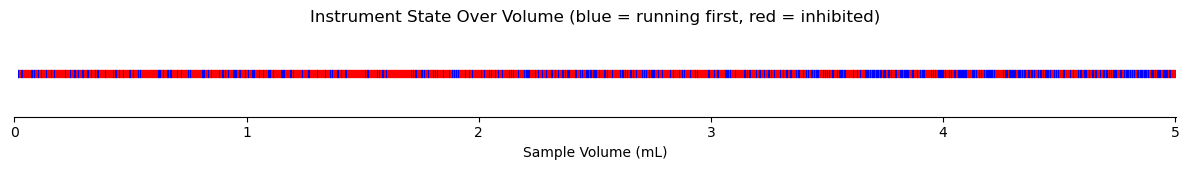

{'total_elapsed_ml': 4.987658094618056, 'total_running_ml': 1.7302792426215292, 'total_inhibited_ml': 3.2573788519965268, 'final_runtime_ml': 5.0043298611111116, 'final_inhibittime_ml': 3.257903067129629, 'rate_ml_per_s': 0.004166666666666667}


In [34]:
summary_ml = plot_instrument_state_volume(adc_df)
print(summary_ml)

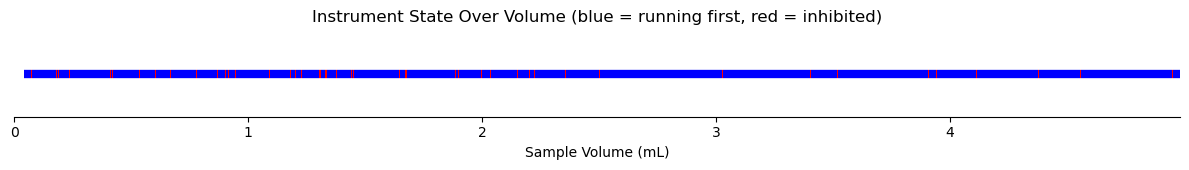

{'total_elapsed_ml': 4.946222601996526, 'total_running_ml': 4.730109402126734, 'total_inhibited_ml': 0.21611319986979174, 'final_runtime_ml': 4.985, 'final_inhibittime_ml': 0.21682541232638888, 'rate_ml_per_s': 0.004166666666666667}


In [35]:
summary_sparce_ml = plot_instrument_state_volume (adc_sparce_df)
print(summary_sparce_ml)

In [36]:
## can we loop this now over a whole directory and stack the outputs with chat anything is possible

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional

def _extract_adc_headers(hdr_path: Path):
    with open(hdr_path, 'r') as f:
        for line in f:
            if line.startswith("ADCFileFormat:"):
                return [h.strip() for h in line.split(":", 1)[1].split(",")]
    raise ValueError(f"ADCFileFormat not found in header file: {hdr_path}")

def _load_adc_for_timeline(adc_path: Path, hdr_path: Path) -> pd.DataFrame:
    headers = _extract_adc_headers(hdr_path)
    df = pd.read_csv(adc_path, header=None)
    df.columns = headers[:df.shape[1]]
    # ensure numeric
    df['RunTime'] = pd.to_numeric(df['RunTime'], errors='coerce')
    df['InhibitTime'] = pd.to_numeric(df['InhibitTime'], errors='coerce')
    df = df.dropna(subset=['RunTime','InhibitTime']).sort_values('RunTime').reset_index(drop=True)
    return df

def plot_directory_timelines_time_inhibit_first(
    data_dir: str,
    abs_tol: float = 1e-6,
    save_path: Optional[str] = None,
    max_files: Optional[int] = None,
):
    """
    Scan a directory for *.hdr / *.adc pairs and plot a single figure with
    a horizontal 'state' strip per sample (red=inhibited first, blue=running).
    Returns a summary DataFrame with totals per sample.

    Parameters
    ----------
    data_dir : str
        Directory to scan recursively.
    abs_tol : float
        Small threshold to treat tiny ΔInhibit as zero (jitter).
    save_path : str or None
        If set, save the figure here (e.g., 'stacked_timelines.png').
    max_files : int or None
        Limit number of samples to plot (useful for quick previews).

    Returns
    -------
    summary_df : pd.DataFrame with columns:
        ['Sample', 'total_elapsed_s', 'total_running_s', 'total_inhibited_s',
         'final_runtime_s', 'final_inhibittime_s']
    """
    data_path = Path(data_dir)
    records = []  # (sample_name, df)

    # find hdr/adc pairs
    for hdr in sorted(data_path.rglob("*.hdr")):
        adc = hdr.with_suffix(".adc")
        if not adc.exists():
            continue
        try:
            df = _load_adc_for_timeline(adc, hdr)
            if len(df) >= 2:
                records.append((hdr.stem, df))
        except Exception as e:
            print(f"Skipping {hdr.stem}: {e}")

        if max_files and len(records) >= max_files:
            break

    if not records:
        print("No valid ADC/HDR pairs found.")
        return pd.DataFrame(columns=[
            'Sample','total_elapsed_s','total_running_s','total_inhibited_s',
            'final_runtime_s','final_inhibittime_s'
        ])

    # Determine global x-limit (max RunTime across samples)
    xmax = max(float(df['RunTime'].max()) for _, df in records)

    # One axes, stack rows by y offset (0..N-1)
    fig, ax = plt.subplots(figsize=(14, 1.1 * len(records) + 1))
    ytick_locs, ytick_labels = [], []

    summaries = []

    for row_idx, (name, df) in enumerate(records):
        line_spacing = 0.2  # smaller = closer lines, default was 1.0
        y0 = float(row_idx) * line_spacing

        # deltas
        dt = df['RunTime'].diff().to_numpy()
        dI = df['InhibitTime'].diff().to_numpy()

        # jitter & clamp
        dI = np.where(dI > abs_tol, dI, 0.0)
        dt = np.where(np.isfinite(dt), dt, 0.0)
        dI = np.where(np.isfinite(dI), dI, 0.0)
        dt = np.where(dt < 0, 0.0, dt)
        dI = np.clip(dI, 0.0, dt)

        x = df['RunTime'].to_numpy()
        total_inhib = 0.0
        total_run = 0.0

        # draw: inhibited (red) first, then running (blue)
        for i in range(1, len(df)):
            x0 = float(x[i-1]); x1 = float(x[i])
            if not np.isfinite(x0) or not np.isfinite(x1) or x1 <= x0:
                continue
            di = float(dI[i])
            dr = float(dt[i] - di)

            cur = x0
            if di > 0:
                ax.plot([cur, cur+di], [y0, y0], color='red', linewidth=20, solid_capstyle='butt')
                cur += di
                total_inhib += di
            if dr > 0:
                ax.plot([cur, x1], [y0, y0], color='blue', linewidth=20, solid_capstyle='butt')
                total_run += dr

        ytick_locs.append(y0)
        ytick_labels.append(name)

        summaries.append({
            'Sample': name,
            'total_elapsed_s': total_run + total_inhib,
            'total_running_s': total_run,
            'total_inhibited_s': total_inhib,
            'final_runtime_s': float(df['RunTime'].iloc[-1]),
            'final_inhibittime_s': float(df['InhibitTime'].iloc[-1]),
        })

    # Style axes
    ax.set_xlim(0, xmax)
    ax.set_ylim(-line_spacing, len(records) * line_spacing)
    ax.set_yticks(ytick_locs)
    ax.set_yticklabels(ytick_labels, fontsize=9)
    ax.set_xlabel("Run Time (s)")
    ax.set_title("Instrument State Over Time (red = inhibited first, blue = running/waiting)")
    ax.grid(False)
    for sp in ['right','top']:
        ax.spines[sp].set_visible(False)

    # # Make a tiny legend line
    # leg_x0, leg_y = xmax * 0.02, len(records) - 0.8
    # ax.plot([leg_x0, leg_x0 + xmax*0.06], [leg_y, leg_y], color='red', linewidth=6)
    # ax.text(leg_x0 + xmax*0.07, leg_y, "Inhibited", va='center', fontsize=9)
    # leg_y2 = leg_y - 0.5
    # ax.plot([leg_x0, leg_x0 + xmax*0.06], [leg_y2, leg_y2], color='blue', linewidth=6)
    # ax.text(leg_x0 + xmax*0.07, leg_y2, "Running/Waiting", va='center', fontsize=9)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved stacked timeline to: {save_path}")
    plt.show()

    summary_df = pd.DataFrame(summaries).sort_values('Sample').reset_index(drop=True)
    return summary_df


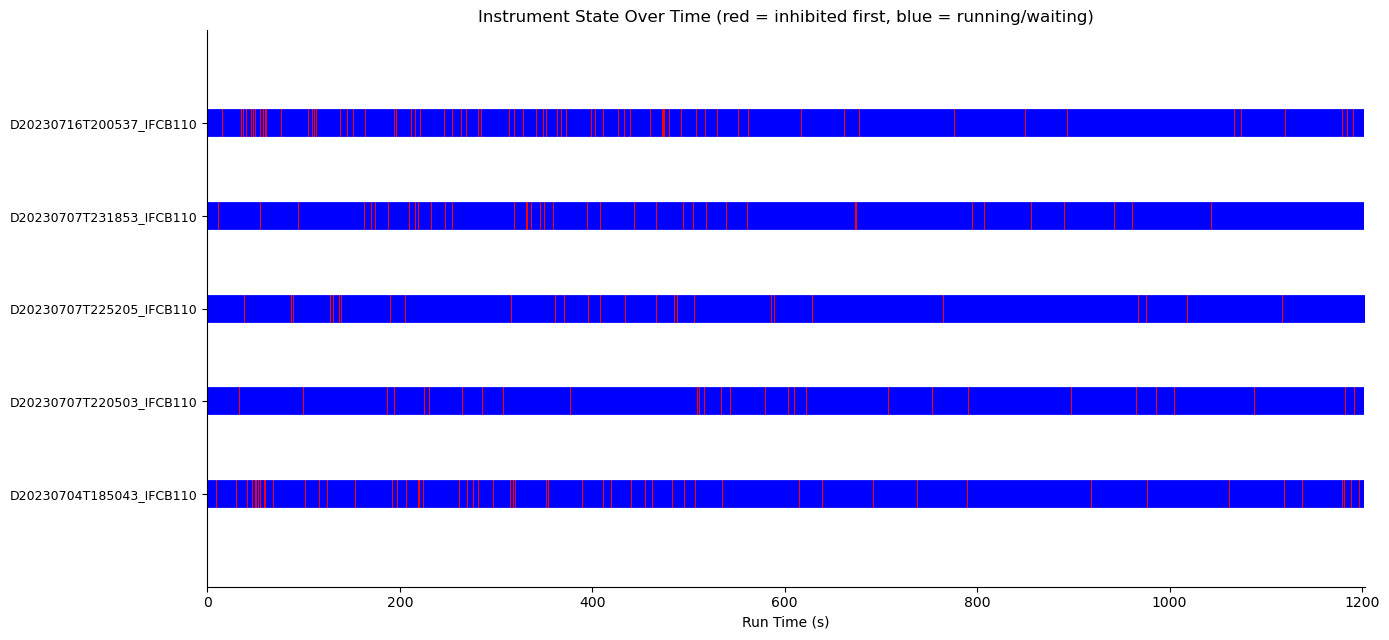

                     Sample  total_elapsed_s  total_running_s  \
0  D20230704T185043_IFCB110      1201.489364      1149.294236   
1  D20230707T220503_IFCB110      1201.550252      1165.909039   
2  D20230707T225205_IFCB110      1202.751478      1172.710299   
3  D20230707T231853_IFCB110      1201.827157      1165.595796   
4  D20230716T200537_IFCB110      1201.548459      1141.310894   

   total_inhibited_s  final_runtime_s  final_inhibittime_s  
0          52.195128      1201.560833            52.205668  
1          35.641213      1201.623333            35.653713  
2          30.041178      1202.824861            30.054028  
3          36.231361      1201.898889            36.243678  
4          60.237565      1201.620139            60.250347  


In [24]:
summary_dir = plot_directory_timelines_time_inhibit_first(
    data_dir= "../IFCBData/h_sampling/")
print(summary_dir)

Saved stacked timeline to: ../Figs/AlexStackedLooktime.png


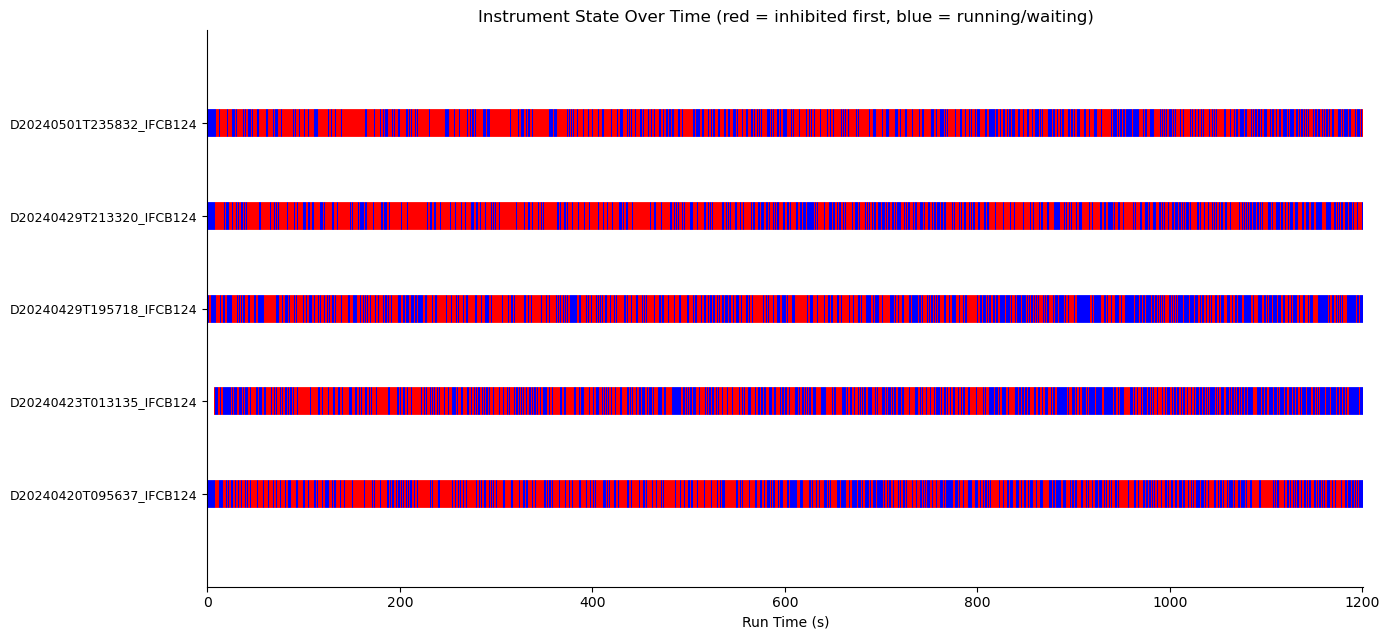

                     Sample  total_elapsed_s  total_running_s  \
0  D20240420T095637_IFCB124      1200.948850       450.631766   
1  D20240423T013135_IFCB124      1193.990540       541.173273   
2  D20240429T195718_IFCB124      1200.865432       554.559599   
3  D20240429T213320_IFCB124      1201.302591       411.585994   
4  D20240501T235832_IFCB124      1200.968162       419.126356   

   total_inhibited_s  final_runtime_s  final_inhibittime_s  
0         750.317083      1201.021528           750.317083  
1         652.817268      1201.246944           652.888472  
2         646.305833      1200.939583           646.305833  
3         789.716597      1201.374722           789.716597  
4         781.841806      1201.039167           781.896736  


In [27]:
# lets do it again for alexandrium dense samples 

summary_dir_alex = plot_directory_timelines_time_inhibit_first( 
    data_dir= "../IFCBData/AlexandriumTest/",
    save_path= "../Figs/AlexStackedLooktime.png")
    
print(summary_dir_alex)
                                                               

### This is pretty sweet so now we could loop this over tons of data to make a nice graph but maybe what we care about is the probability that it is looking at any second this would be like make note of where along these lines it is plotted red vs blue and compare throughout visually it looks like much redder at the start than at the end as we expect. 

### Can we calculate a proportion of time when looking -- does this matter i think it does like what I want to know if what is the prob at any given time that we are looking can get this empyrically and leave modeling for another time


What we are doing here is looping the same logic as above and now binning each second (this is adjustable) and saying is it inhibited or is it running then looking at it graphically so we can see over time how that proportion changes -- I could do this on posiedon over a ton of salt pond data and get a pretty good idea of what this looks like 



In [50]:
def compute_inhibit_probability(records, abs_tol=1e-6, bin_size=1.0):
    """
    records: list of (name, adc_df) with RunTime & InhibitTime.
    Returns a DataFrame with columns: time_center_s, p_running, p_inhibited, n_active.
    """
    max_runtime = max(float(df['RunTime'].max()) for _, df in records)
    time_bins = np.arange(0, max_runtime + bin_size, bin_size)
    bin_centers = time_bins[:-1] + bin_size / 2

    inhibited_counts = np.zeros(len(bin_centers))
    active_counts = np.zeros(len(bin_centers))

    for _, df in records:
        dt = df['RunTime'].diff().to_numpy()
        dI = df['InhibitTime'].diff().to_numpy()

        # kill jitter & clamp
        dI = np.where(dI > abs_tol, dI, 0.0)
        dt = np.where(np.isfinite(dt), dt, 0.0)
        dI = np.where(np.isfinite(dI), dI, 0.0)
        dt = np.where(dt < 0, 0.0, dt)
        dI = np.clip(dI, 0.0, dt)

        # build segments (start, end, state)
        x = df['RunTime'].to_numpy()
        segments = []
        for i in range(1, len(df)):
            x0 = float(x[i-1]); x1 = float(x[i])
            if not np.isfinite(x0) or not np.isfinite(x1) or x1 <= x0:
                continue
            di = float(dI[i]); dr = float(dt[i] - di)
            cur = x0
            if di > 0:
                segments.append((cur, cur+di, 'inhib')); cur += di
            if dr > 0:
                segments.append((cur, x1, 'run'))

        # bin segments (simple coverage count)
        for start, end, state in segments:
            if end <= start:
                continue
            start_bin = int(start // bin_size)
            end_bin = int((end - 1e-12) // bin_size)
            for b in range(max(0, start_bin), min(len(bin_centers)-1, end_bin)+1):
                active_counts[b] += 1
                if state == 'inhib':
                    inhibited_counts[b] += 1

    p_inhibited = np.divide(inhibited_counts, active_counts, out=np.zeros_like(inhibited_counts), where=active_counts>0)
    p_running = 1 - p_inhibited

    return pd.DataFrame({
        'time_center_s': bin_centers,
        'p_running': p_running,
        'p_inhibited': p_inhibited,
        'n_active': active_counts
    })

# --- one-call plotter over a directory ---
def plot_proportion_running_over_time(data_dir, bin_size=1.0, abs_tol=1e-4, max_files=None, save_path=None):
    data_path = Path(data_dir)
    records = []
    for hdr in sorted(data_path.rglob("*.hdr")):
        adc = hdr.with_suffix(".adc")
        if not adc.exists():
            continue
        try:
            df = _load_adc_for_timeline(adc, hdr)
            if len(df) >= 2:
                records.append((hdr.stem, df))
        except Exception as e:
            print(f"Skipping {hdr.stem}: {e}")
        if max_files and len(records) >= max_files:
            break

    if not records:
        print("No valid ADC/HDR pairs found.")
        return None

    prob_df = compute_inhibit_probability(records, abs_tol=abs_tol, bin_size=bin_size)

    plt.figure(figsize=(12, 4))
    plt.plot(prob_df['time_center_s'], prob_df['p_running'], label='Proportion Running', linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Proportion Running")
    plt.ylim(0, 1)
    plt.title("IFCB Proportion Running Over Time (binned)")
    plt.grid(True, alpha=0.25)
    # show how many runs contribute (optional helper axis)
    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.plot(prob_df['time_center_s'], prob_df['n_active'], alpha=0.3, linestyle='--')
    ax2.set_ylabel("# Active Runs (info)")
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")
    plt.show()

    return prob_df

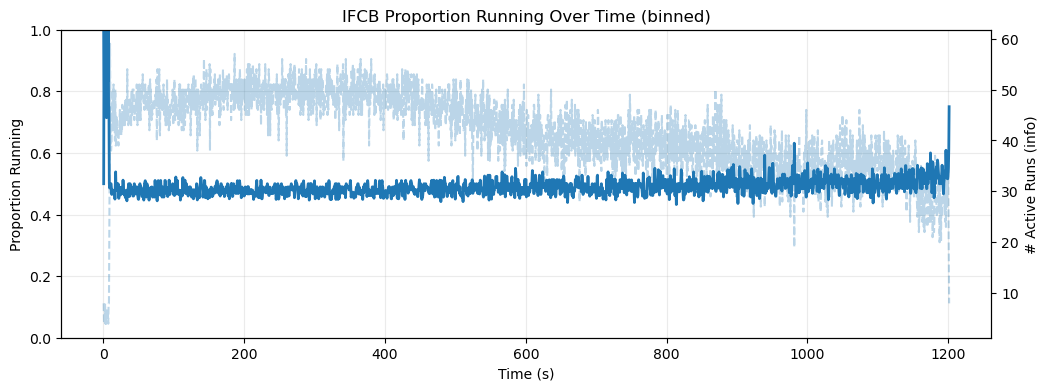

In [52]:
prob_df = plot_proportion_running_over_time(
    data_dir="../AlexandriumTest/",
    bin_size=.5,           # seconds; try 2–5s for smoother curves
    abs_tol=1e-4,           # jitter tolerance on ΔInhibit
    max_files=None,         # or an int to preview with fewer runs
    save_path=None
)

I dont really think this is right but a problem for another day

## Trying to create heatmap of roi size over run time

In [28]:
print(adc_df.columns.to_list())

['trigger#', 'ADCtime', 'PMTA', 'PMTB', 'PMTC', 'PMTD', 'PeakA', 'PeakB', 'PeakC', 'PeakD', 'TimeOfFlight', 'GrabTimeStart', 'GrabTimeEnd', 'RoiX', 'RoiY', 'RoiWidth', 'RoiHeight', 'StartByte', 'ComparatorOut', 'StartPoint', 'SignalLength', 'Status', 'RunTime', 'InhibitTime', 'RoiNumber', 'InhibitTimeDiff', 'VolumeAnalyzed']


In [29]:
# creat roi area
adc_df['RoiArea']=adc_df['RoiHeight'] * adc_df['RoiWidth']
print(adc_df['RoiArea'].head())

1    48608
2     7616
3     6688
4    14688
5     3744
Name: RoiArea, dtype: int64


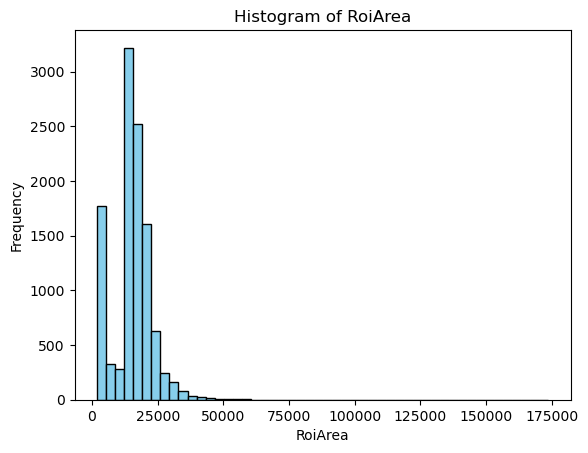

Min 2016 Max 173664


In [31]:
# explore distribution
import matplotlib.pyplot as plt

# Create histogram
plt.hist(adc_df['RoiArea'], bins=50, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('RoiArea')
plt.ylabel('Frequency')
plt.title('Histogram of RoiArea')

# Show the plot
plt.savefig("../Figs/HistOfRoiAreaSingleBin.png")
plt.show()
print('Min', adc_df['RoiArea'].min(), 'Max', adc_df['RoiArea'].max())

# now can we create a heat map with this binned into four size classes -- 0-15000, 15000-30000, 30000-45000, 45000- 
### we want them to be relative to the number of images in that size class I think we dont care about absolute numnbers we only want relative

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [102]:

# # Define size bins
# size_bins = [0, 15000, 30000, 45000, np.inf]
# size_labels = ['0-15k', '15k-30k', '30k-45k', '>45k']
# adc_df['RoiArea_bin'] = pd.cut(adc_df['RoiArea'], bins=size_bins, labels=size_labels)

# # Define RunTime bins (e.g., every 10 seconds)
# n = 10  # seconds per bin, change as needed
# adc_df['RunTime_bin'] = (adc_df['RunTime'] // n) * n  # floor division to bin


In [103]:
# # Group by time bin and size bin, count observations
# counts = adc_df.groupby(['RunTime_bin', 'RoiArea_bin']).size().reset_index(name='count')

# # Pivot table: RoiArea_bin as rows, RunTime_bin as columns
# pivot = counts.pivot(index='RoiArea_bin', columns='RunTime_bin', values='count').fillna(0)

# # Check the result
# print(pivot.head())


In [104]:
# import matplotlib.pyplot as plt

# # Figure
# fig, axes = plt.subplots(nrows=len(size_labels), ncols=1, figsize=(14, 8), sharex=True)

# # Use global min/max for color scale
# vmin = 0
# vmax = pivot.values.max()

# for i, size_label in enumerate(size_labels):
#     data = pivot.loc[size_label].values[np.newaxis, :]  # shape (1, num_time_bins)
    
#     im = axes[i].imshow(data, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
    
#     axes[i].set_yticks([0])
#     axes[i].set_yticklabels([size_label], rotation=0, fontsize=12)
    
#     # Only bottom x-axis shows time bin labels
#     axes[i].set_xticks([] if i != len(size_labels)-1 else range(len(pivot.columns)))
#     if i == len(size_labels)-1:
#         # Show only every 500 seconds
#         tick_interval = 300
#         all_bins = pivot.columns.values
#         tick_positions = [i for i, t in enumerate(all_bins) if t % tick_interval == 0]
#         tick_labels = [all_bins[i] for i in tick_positions]
#         axes[i].set_xticks(tick_positions)
#         axes[i].set_xticklabels(tick_labels, rotation=45, fontsize=10)
    
#     axes[i].set_ylabel('')

# # Single colorbar on the right
# cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
# cbar.set_label('Count of observations')


# plt.show()


In [105]:
# pivot: RoiArea_bin x RunTime_bin with absolute counts
pivot_rel_size = pivot.div(pivot.sum(axis=1), axis=0)  # divide by sum per row (size bin)


In [106]:
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(nrows=len(size_labels), ncols=1, figsize=(14, 8), sharex=True)

# for i, size_label in enumerate(size_labels):
#     # Get data for this size bin
#     data = pivot_rel_size.loc[size_label].values[np.newaxis, :]  # shape (1, num_time_bins)
    
#     # Set vmax for this row based on its own max (optional: vmin=0)
#     row_max = data.max()
    
#     # Plot heatmap
#     im = axes[i].imshow(data, aspect='auto', cmap='viridis', vmin=0, vmax=row_max)
    
#     axes[i].set_yticks([0])
#     axes[i].set_yticklabels([size_label], rotation=0, fontsize=12)
    
#     # Only bottom heatmap shows x-axis labels
#     axes[i].set_xticks([] if i != len(size_labels)-1 else range(len(pivot.columns)))
#     if i == len(size_labels)-1:
#         tick_interval = 500
#         all_bins = pivot.columns.values
#         tick_positions = [i for i, t in enumerate(all_bins) if t % tick_interval == 0]
#         tick_labels = [all_bins[i] for i in tick_positions]
#         axes[i].set_xticks(tick_positions)
#         axes[i].set_xticklabels(tick_labels, rotation=45, fontsize=10)
    
#     # Individual colorbar for this row
#     cbar = fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.02, pad=0.02)
#     cbar.set_label('Relative abundance within size bin')

# plt.tight_layout()
# plt.show()


In [107]:
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(nrows=len(size_labels), ncols=1, figsize=(14, 8), sharex=True)

# for i, size_label in enumerate(size_labels):
#     # Get absolute counts for this size bin
#     data = pivot.loc[size_label].values[np.newaxis, :]  # shape (1, num_time_bins)
    
#     # Set vmax based on this row's max (so colorbar is independent)
#     row_max = data.max()
    
#     # Plot heatmap
#     im = axes[i].imshow(data, aspect='auto', cmap='viridis', vmin=0, vmax=row_max)
    
#     axes[i].set_yticks([0])
#     axes[i].set_yticklabels([size_label], rotation=0, fontsize=12)
    
#     # Only bottom heatmap shows x-axis labels
#     axes[i].set_xticks([] if i != len(size_labels)-1 else range(len(pivot.columns)))
#     if i == len(size_labels)-1:
#         tick_interval = 500
#         all_bins = pivot.columns.values
#         tick_positions = [i for i, t in enumerate(all_bins) if t % tick_interval == 0]
#         tick_labels = [all_bins[i] for i in tick_positions]
#         axes[i].set_xticks(tick_positions)
#         axes[i].set_xticklabels(tick_labels, rotation=45, fontsize=10)
    
#     # Add individual colorbar for this heatmap
#     cbar = fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.02, pad=0.02)
#     cbar.set_label('Absolute count')

# plt.tight_layout()
# plt.show()


### so this will bin roi area into four size classes, then bin every n seconds, then plot the absolute abundance of of each particle size in each time bin

#### what I want to do now is loop this over lots of data and see if it matches with what we expect

what this does:

Within the data frame there will be several matched pairs of .adc and .hdr files that have the same startig string with either .hdr or .adc. I would like to for each pair of these files 
1. use this function to load the adc file and extract the column names from the hdr file
def extract_adc_headers(hdr_file_path):
    """
    Extracts the ADCFileFormat headers from a .hdr file.
    """
    with open(hdr_file_path, 'r') as file:
        for line in file:
            if line.startswith("ADCFileFormat:"):
                header_line = line.strip().split(":", 1)[1]
                headers = [h.strip() for h in header_line.split(",")]
                return headers
    raise ValueError("ADCFileFormat not found in header file.")

def load_adc_data(adc_file_path, headers):
    """
    Loads the .adc file and applies the given headers to the DataFrame.
    """
    df = pd.read_csv(adc_file_path, header=None)
    df.columns = headers[:df.shape[1]]  # Handle case where fewer headers than columns
    return df

def main(hdr_path, adc_path):
    headers = extract_adc_headers(hdr_path)
    adc_df = load_adc_data(adc_path, headers)
    return adc_df

2.  Use this function to clean add roi numnbers and then clean zero rois from the .adc file 


def clean_ADC_roi(df):
    """
    Remove rows from a DataFrame where RoiX, RoiY, RoiHeight, and RoiWidth are all 0.
    Returns a new cleaned DataFrame.
    """
    df['RoiNumber'] = range(1, len(df) + 1)
    cleandf = df[~((df['RoiX'] == 0) & (df['RoiY'] == 0) &
                   (df['RoiHeight'] == 0) & (df['RoiWidth'] == 0))]

    print(f"Removed {len(df) - len(cleandf)} rows.")
    return cleandf

3. Calculate RoiArea 
adc_df['RoiArea']=adc_df['RoiHeight'] * adc_df['RoiWidth']

4. Bin by size and time this should be a parameter we can enter on how to divide the bins but the same or similar to this
#### Define size bins
size_bins = [0, 15000, 30000, 45000, np.inf]
size_labels = ['0-15k', '15k-30k', '30k-45k', '>45k']
adc_df['RoiArea_bin'] = pd.cut(adc_df['RoiArea'], bins=size_bins, labels=size_labels)

#### Define RunTime bins (e.g., every 10 seconds)
n = 10  # seconds per bin, change as needed
adc_df['RunTime_bin'] = (adc_df['RunTime'] // n) * n  # floor division to bin

5. Then save these values to a dataframe AreaOverTime that should be pivoted like this
#### Group by time bin and size bin, count observations
counts = adc_df.groupby(['RunTime_bin', 'RoiArea_bin']).size().reset_index(name='count')

#### Pivot table: RoiArea_bin as rows, RunTime_bin as columns
pivot = counts.pivot(index='RoiArea_bin', columns='RunTime_bin', values='count').fillna(0)

#### Check the result
print(pivot.head())

6. Then repeat the process with another pair of .hdr and .adc files and at the end I would like to add the values computed for each size bin and time bin to the corosponding bin in the aggregate dataframe. 

We will then use this aggregate dataframe to create heat maps in the same way we have before



In [33]:
import pandas as pd
import numpy as np
from pathlib import Path

# Step 1: Functions to load ADC and HDR
def extract_adc_headers(hdr_file_path):
    """
    Extracts the ADCFileFormat headers from a .hdr file.
    """
    with open(hdr_file_path, 'r') as file:
        for line in file:
            if line.startswith("ADCFileFormat:"):
                header_line = line.strip().split(":", 1)[1]
                headers = [h.strip() for h in header_line.split(",")]
                return headers
    raise ValueError(f"ADCFileFormat not found in header file: {hdr_file_path}")

def load_adc_data(adc_file_path, headers):
    """
    Loads the .adc file and applies the given headers to the DataFrame.
    """
    df = pd.read_csv(adc_file_path, header=None)
    df.columns = headers[:df.shape[1]]  # Handle case where fewer headers than columns
    return df

# Step 2: Clean ADC
def clean_ADC_roi(df):
    """
    Add RoiNumber and remove rows with RoiX, RoiY, RoiHeight, RoiWidth all 0.
    """
    df['RoiNumber'] = range(1, len(df) + 1)
    cleandf = df[~((df['RoiX'] == 0) & (df['RoiY'] == 0) &
                   (df['RoiHeight'] == 0) & (df['RoiWidth'] == 0))]
    print(f"Removed {len(df) - len(cleandf)} zero-ROI rows.")
    return cleandf

# --- Main aggregation function ---
def aggregate_ifcb_area_over_time(data_dir, size_bins=None, size_labels=None, time_bin_size=10):
    """
    Aggregate multiple IFCB ADC/HDR files into a pivot table of counts
    by RoiArea_bin and RunTime_bin.

    Args:
        data_dir (str or Path): Folder containing paired .adc and .hdr files
        size_bins (list): List of bin edges for RoiArea
        size_labels (list): Labels for RoiArea bins
        time_bin_size (int): Seconds per time bin

    Returns:
        pd.DataFrame: Aggregate pivot table ready for heatmap plotting
    """
    data_dir = Path(data_dir)
    
    if size_bins is None:
        size_bins = [0, 15000, 30000, 45000, np.inf]
    if size_labels is None:
        size_labels = ['0-15k', '15k-30k', '30k-45k', '>45k']
    
    # Initialize empty DataFrame for aggregation
    aggregate_df = pd.DataFrame()
    
    # --- Loop over all .adc files
    for adc_file in data_dir.glob("*.adc"):
        stem = adc_file.stem
        hdr_file = adc_file.with_suffix(".hdr")
        
        if not hdr_file.exists():
            print(f"Skipping {stem}: missing .hdr file.")
            continue
        
        try:
            # Step 1: load data
            headers = extract_adc_headers(hdr_file)
            adc_df = load_adc_data(adc_file, headers)
            
            # Step 2: clean
            adc_df = clean_ADC_roi(adc_df)
            
            # Step 3: calculate RoiArea
            adc_df['RoiArea'] = adc_df['RoiHeight'] * adc_df['RoiWidth']
            
            # Step 4: bin by size and time
            adc_df['RoiArea_bin'] = pd.cut(adc_df['RoiArea'], bins=size_bins, labels=size_labels)
            adc_df['RunTime_bin'] = (adc_df['RunTime'] // time_bin_size) * time_bin_size
            
            # Step 5: group and pivot
            counts = adc_df.groupby(['RoiArea_bin', 'RunTime_bin']).size().reset_index(name='count')
            pivot = counts.pivot(index='RoiArea_bin', columns='RunTime_bin', values='count').fillna(0)
            
            # Step 6: aggregate
            if aggregate_df.empty:
                aggregate_df = pivot
            else:
                # Add counts to existing aggregate (align indices and columns)
                aggregate_df = aggregate_df.add(pivot, fill_value=0)
                
            print(f"Processed {stem}, shape: {pivot.shape}")
            
        except Exception as e:
            print(f"Error processing {stem}: {e}")
    
    # Ensure integer counts
    aggregate_df = aggregate_df.fillna(0).astype(int)
    
    return aggregate_df


In [34]:
data_dir = "../IFCBData/AlexandriumTest/"
aggregate_pivot = aggregate_ifcb_area_over_time(
    data_dir,
    size_bins=[0, 15000, 30000, 45000, np.inf],
    size_labels=['0-15k','15k-30k','30k-45k','>45k'],
    time_bin_size=10
)

print(aggregate_pivot.head())


Removed 1 zero-ROI rows.
Processed D20240501T235832_IFCB124, shape: (4, 121)
Removed 1 zero-ROI rows.
Processed D20240429T195718_IFCB124, shape: (4, 121)
Removed 5 zero-ROI rows.
Processed D20240423T013135_IFCB124, shape: (4, 121)
Removed 4 zero-ROI rows.
Processed D20240429T213320_IFCB124, shape: (4, 121)
Removed 5 zero-ROI rows.
Processed D20240420T095637_IFCB124, shape: (4, 121)
RunTime_bin  0.0     10.0    20.0    30.0    40.0    50.0    60.0    70.0    \
RoiArea_bin                                                                   
0-15k            31     172     133     149     148     132     132     130   
15k-30k          48     203     213     238     248     244     245     243   
30k-45k          12      66      71      78      73     101      85      95   
>45k              3       7      12      11      12       4      13       5   

RunTime_bin  80.0    90.0    ...  1110.0  1120.0  1130.0  1140.0  1150.0  \
RoiArea_bin                  ...                                

/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_58410/797139230.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adc_df.groupby(['RoiArea_bin', 'RunTime_bin']).size().reset_index(name='count')
/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_58410/797139230.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adc_df.groupby(['RoiArea_bin', 'RunTime_bin']).size().reset_index(name='count')
/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_58410/797139230.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future v

In [95]:
print(aggregate_pivot.index.to_list())

['0-15k', '15k-30k', '30k-45k', '>45k']


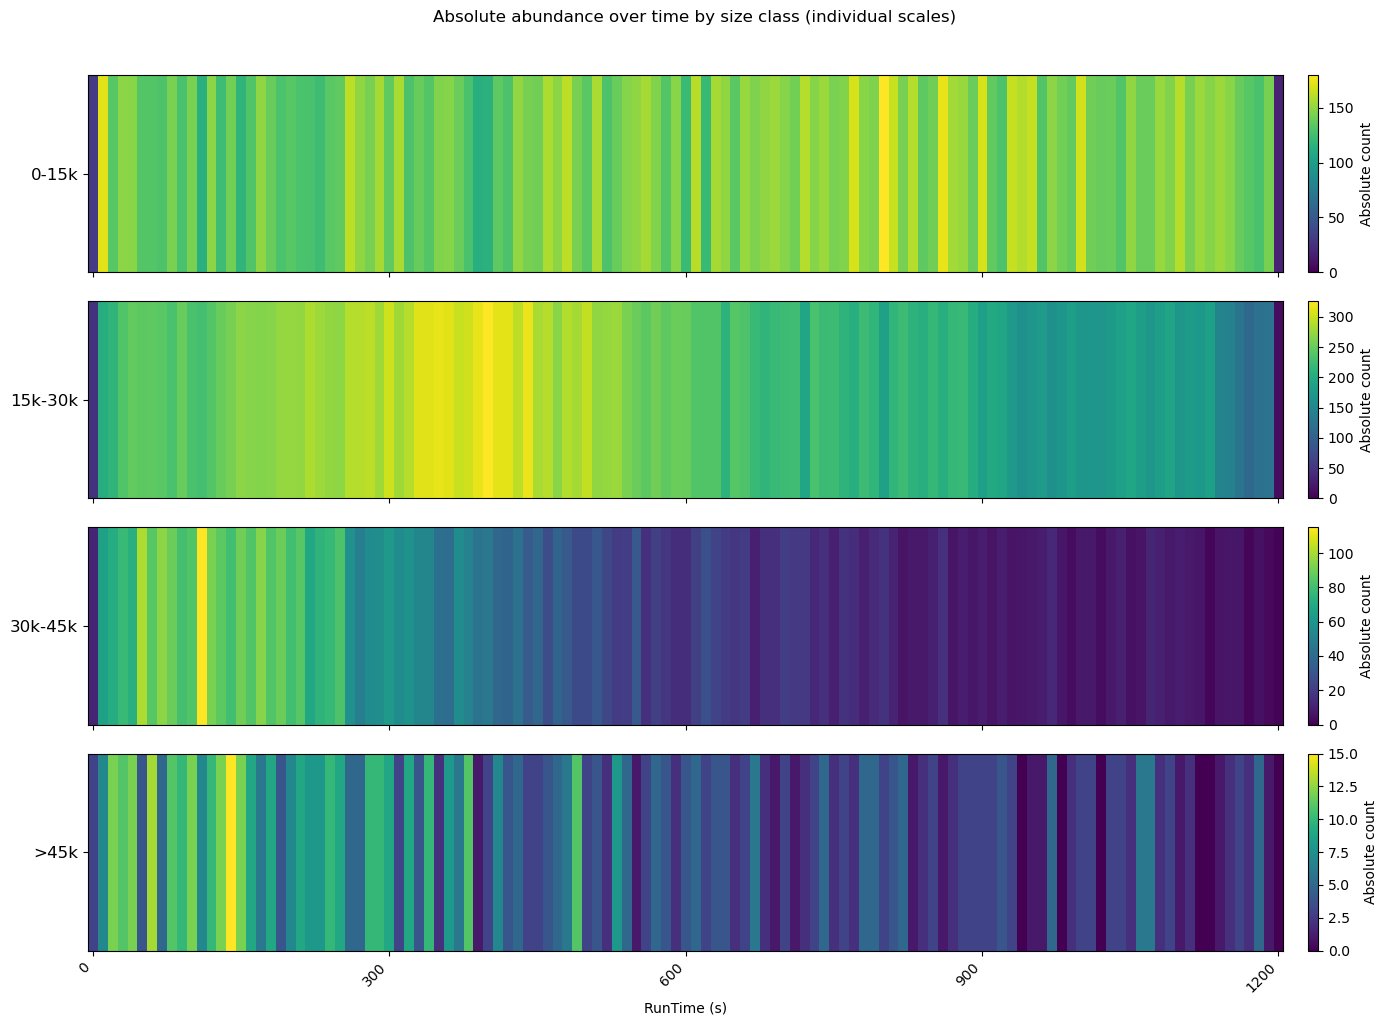

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- If you already have `aggregate_pivot` as a DataFrame, start here ---
# Rows: RoiArea_bin (e.g., '0-15k', '15k-30k', ...)
# Cols: RunTime_bin (e.g., 0, 10, 20, ...)

# Ensure time-bin columns are numeric and sorted
def to_numeric_time_cols(dfi: pd.DataFrame) -> pd.DataFrame:
    numeric = {}
    for c in dfi.columns:
        try:
            numeric[int(c)] = dfi[c]
        except Exception:
            try:
                numeric[int(float(c))] = dfi[c]
            except Exception:
                # Drop anything that can't be interpreted as a number
                pass
    out = pd.DataFrame(numeric, index=dfi.index).sort_index(axis=1)
    return out

df_num = to_numeric_time_cols(aggregate_pivot)

# --- Plot: one strip per size class, each with its own colorbar ---
tick_interval = 300  # label every 500 seconds on the bottom axis

n_bins = len(df_num.index)
fig, axes = plt.subplots(n_bins, 1, figsize=(14, 2.5 * n_bins), sharex=True)

if n_bins == 1:
    axes = [axes]

cols = df_num.columns.to_numpy()

for i, (size_class, ax) in enumerate(zip(df_num.index, axes)):
    data = df_num.loc[size_class].values[np.newaxis, :]  # shape (1, n_time_bins)

    # Independent color scale per strip
    vmax = float(np.nanmax(data)) if np.isfinite(np.nanmax(data)) else 0.0
    im = ax.imshow(data, aspect="auto", cmap="viridis", vmin=0, vmax=vmax if vmax > 0 else 1)

    # Y label = size class
    ax.set_yticks([0])
    ax.set_yticklabels([size_class], rotation=0, fontsize=12)

    # X ticks only on bottom plot
    if i == n_bins - 1:
        tick_pos = [j for j, t in enumerate(cols) if isinstance(t, (int, np.integer)) and t % tick_interval == 0]
        tick_lab = [cols[j] for j in tick_pos]
        if not tick_pos:  # fallback if no multiples of tick_interval
            n_show = min(10, len(cols))
            tick_pos = np.linspace(0, len(cols) - 1, n_show, dtype=int).tolist()
            tick_lab = [int(cols[j]) for j in tick_pos]
        ax.set_xticks(tick_pos)
        ax.set_xticklabels(tick_lab, rotation=45, ha="right")
        ax.set_xlabel("RunTime (s)")
    else:
        ax.set_xticks([])

    # Individual colorbar
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.02)
    cbar.set_label("Absolute count")

plt.suptitle("Absolute abundance over time by size class (individual scales)", y=1.02)
plt.tight_layout()
plt.savefig('../Figs/SizeClassBinHeatmap.png')
plt.show()


## this is cool but is it right? like absolute count could be misleading here i feel like i want relative but i am not sure relative to what but what it does do is show that there is some pretty obvious settling. what if i do it to the h test data set

In [100]:
data_dir = "../h_sampling/"
aggregate_h_pivot = aggregate_ifcb_area_over_time(
    data_dir,
    size_bins=[0, 15000, 30000, 45000, np.inf],
    size_labels=['0-15k','15k-30k','30k-45k','>45k'],
    time_bin_size=10
)

print(aggregate_pivot.head())

Removed 70 zero-ROI rows.
Processed D20230707T225205_IFCB110, shape: (4, 95)
Removed 82 zero-ROI rows.
Processed D20230707T220503_IFCB110, shape: (4, 107)
Removed 150 zero-ROI rows.
Processed D20230716T200537_IFCB110, shape: (4, 111)
Removed 63 zero-ROI rows.
Processed D20230704T185043_IFCB110, shape: (4, 116)
Removed 83 zero-ROI rows.
Processed D20230707T231853_IFCB110, shape: (4, 100)
RunTime_bin  0.0     10.0    20.0    30.0    40.0    50.0    60.0    70.0    \
RoiArea_bin                                                                   
0-15k            31     172     133     149     148     132     132     130   
15k-30k          48     203     213     238     248     244     245     243   
30k-45k          12      66      71      78      73     101      85      95   
>45k              3       7      12      11      12       4      13       5   

RunTime_bin  80.0    90.0    ...  1110.0  1120.0  1130.0  1140.0  1150.0  \
RoiArea_bin                  ...                           

/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_10561/797139230.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adc_df.groupby(['RoiArea_bin', 'RunTime_bin']).size().reset_index(name='count')
/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_10561/797139230.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adc_df.groupby(['RoiArea_bin', 'RunTime_bin']).size().reset_index(name='count')
/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_10561/797139230.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future v

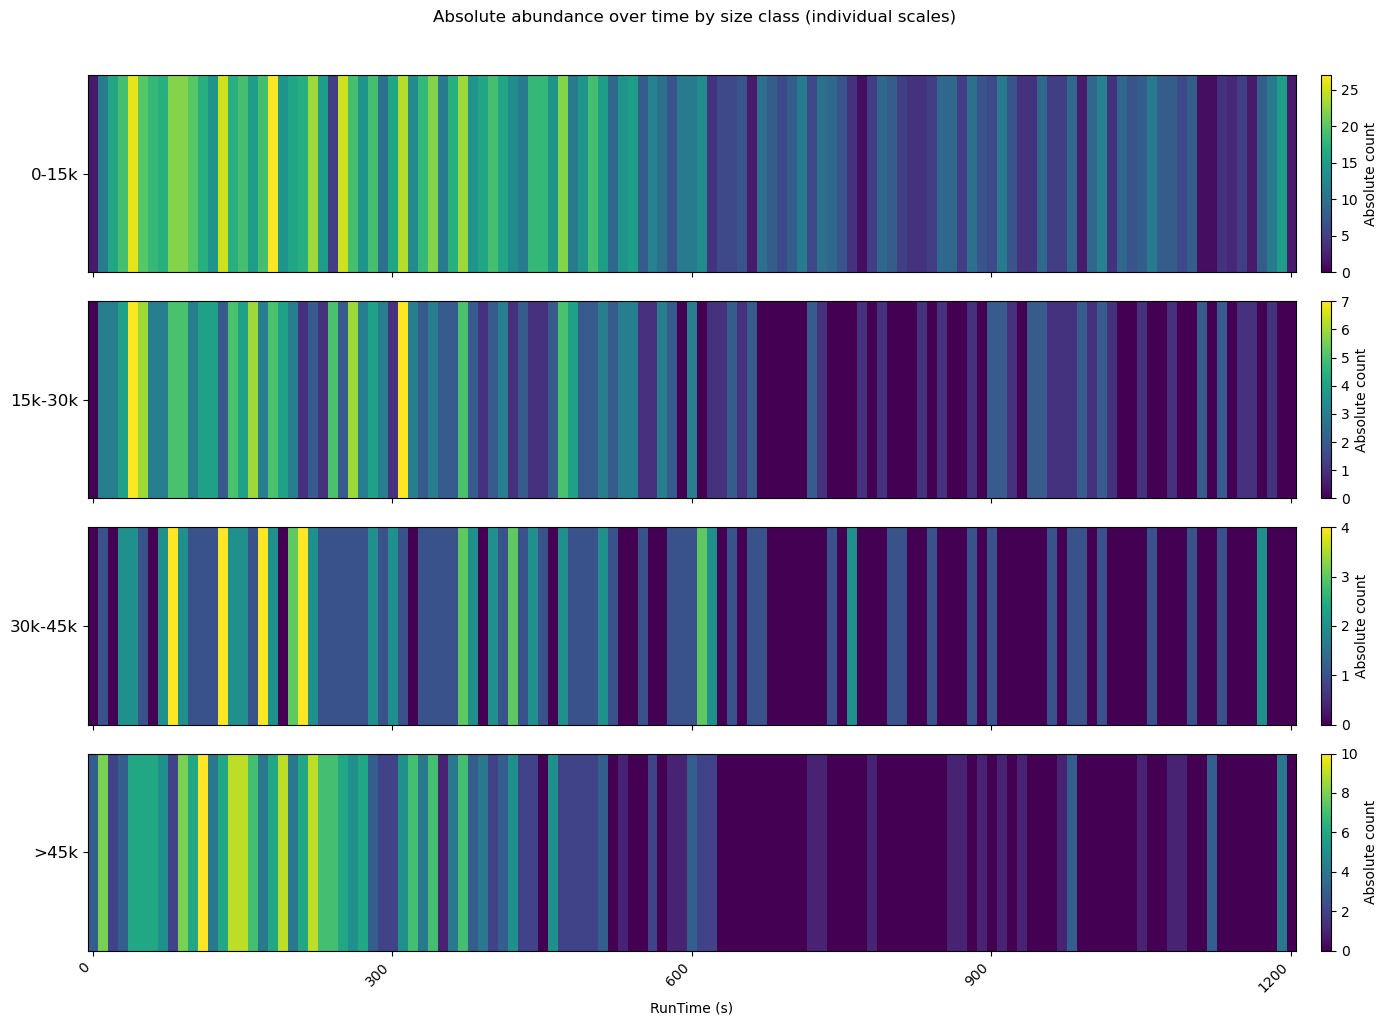

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- If you already have `aggregate_pivot` as a DataFrame, start here ---
# Rows: RoiArea_bin (e.g., '0-15k', '15k-30k', ...)
# Cols: RunTime_bin (e.g., 0, 10, 20, ...)

# Ensure time-bin columns are numeric and sorted
def to_numeric_time_cols(dfi: pd.DataFrame) -> pd.DataFrame:
    numeric = {}
    for c in dfi.columns:
        try:
            numeric[int(c)] = dfi[c]
        except Exception:
            try:
                numeric[int(float(c))] = dfi[c]
            except Exception:
                # Drop anything that can't be interpreted as a number
                pass
    out = pd.DataFrame(numeric, index=dfi.index).sort_index(axis=1)
    return out

df_num = to_numeric_time_cols(aggregate_h_pivot)

# --- Plot: one strip per size class, each with its own colorbar ---
tick_interval = 300  # label every 500 seconds on the bottom axis

n_bins = len(df_num.index)
fig, axes = plt.subplots(n_bins, 1, figsize=(14, 2.5 * n_bins), sharex=True)

if n_bins == 1:
    axes = [axes]

cols = df_num.columns.to_numpy()

for i, (size_class, ax) in enumerate(zip(df_num.index, axes)):
    data = df_num.loc[size_class].values[np.newaxis, :]  # shape (1, n_time_bins)

    # Independent color scale per strip
    vmax = float(np.nanmax(data)) if np.isfinite(np.nanmax(data)) else 0.0
    im = ax.imshow(data, aspect="auto", cmap="viridis", vmin=0, vmax=vmax if vmax > 0 else 1)

    # Y label = size class
    ax.set_yticks([0])
    ax.set_yticklabels([size_class], rotation=0, fontsize=12)

    # X ticks only on bottom plot
    if i == n_bins - 1:
        tick_pos = [j for j, t in enumerate(cols) if isinstance(t, (int, np.integer)) and t % tick_interval == 0]
        tick_lab = [cols[j] for j in tick_pos]
        if not tick_pos:  # fallback if no multiples of tick_interval
            n_show = min(10, len(cols))
            tick_pos = np.linspace(0, len(cols) - 1, n_show, dtype=int).tolist()
            tick_lab = [int(cols[j]) for j in tick_pos]
        ax.set_xticks(tick_pos)
        ax.set_xticklabels(tick_lab, rotation=45, ha="right")
        ax.set_xlabel("RunTime (s)")
    else:
        ax.set_xticks([])

    # Individual colorbar
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.02)
    cbar.set_label("Absolute count")

plt.suptitle("Absolute abundance over time by size class (individual scales)", y=1.02)
plt.tight_layout()
plt.savefig('../AlexandriumTest/figs/SizeClassBinHeatmap.png')
plt.show()


In [ ]:
###  i might need alot more data here